# Library


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
 
# importing stacking lib
from vecstack import stacking

# Load Data

In [2]:
# path
ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


# get all ticker name
def ticker_name(data_ticker):
    return data_ticker['ticker'].unique().tolist()

# get data of a specific ticker
def take_data_ticker(data_ticker, name_ticker):
    data_source = []
    for ticker in name_ticker:
        filtered_data = data_ticker[data_ticker['ticker'] == ticker]
        data_source.append(filtered_data)
    return data_source



code_ticker_taken = ['SSI','SHS','HPG','HSG','TCB']

data_full = take_data_ticker(ticker_data, code_ticker_taken)

/tmp/ipykernel_81123/1387478507.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


In [3]:
data_full[0]

,time,open,high,low,close,volume,ticker,industry
0,2018-10-29,12500,12530,12320,12460,1971190,SSI,Dịch vụ tài chính
1,2018-10-30,12500,12800,12340,12500,1967410,SSI,Dịch vụ tài chính
2,2018-10-31,12730,13090,12660,13030,2418880,SSI,Dịch vụ tài chính
3,2018-11-01,13070,13090,12710,12730,2372190,SSI,Dịch vụ tài chính
4,2018-11-02,12840,13180,12780,13090,3357100,SSI,Dịch vụ tài chính
...,...,...,...,...,...,...,...,...
1247,2023-10-24,31000,31150,30450,31050,14254500,SSI,Dịch vụ tài chính
1248,2023-10-25,31000,31550,30800,30800,14381400,SSI,Dịch vụ tài chính
1249,2023-10-26,29700,29950,28650,28700,54159900,SSI,Dịch vụ tài chính
1250,2023-10-27,29250,29800,28750,29450,20052100,SSI,Dịch vụ tài chính


# Technical Indicator

MA


In [4]:
# Simple Moving Average 
def SMA(data, ndays): 
    sma_column_name = f'MA{ndays}'
    SMA = pd.Series(data['close'].rolling(ndays).mean(), name=sma_column_name) 
    data = data.join(SMA)
    return data 

data_MA = []

for data in data_full:

    # Compute the 10-day EWMA
    n1 = 10
    data = SMA(data, n1)  

    # Compute the 20-day EWMA
    n2 = 20
    data = SMA(data, n2)  

    # Compute the 50-day SMA
    n3 = 50
    data = SMA(data, n3)  

    # Compute the 200-day SMA
    n4 = 200
    data = SMA(data, n4)  
    data_MA.append(data)

# # Plot
# fig, ax = plt.subplots(figsize=(20,7))
# plt.title('Moving Average')
# plt.xlabel('Date')
# plt.ylabel('Price')

# # Plot close price and moving averages
# plt.plot(data['time'], data['close'], lw=1, label='Close Price')
# plt.plot(data['time'], data['MA10'], 'g', lw=1, label='MA10')
# plt.plot(data['time'], data['MA20'], 'b', lw=1, label='MA20')
# plt.plot(data['time'], data['MA50'], 'y', lw=1, label='MA50')
# plt.plot(data['time'], data['MA200'], 'r', lw=1, label='MA200')
# ax.xaxis.set_major_locator(ticker.MaxNLocator(17))  
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Add a legend to the axis
# plt.legend()
# plt.show()


RSI

In [5]:
# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, n):
    delta = data['close'].diff()  # Calculate price differences
    gain = delta.where(delta > 0, 0)  # Positive price differences
    loss = -delta.where(delta < 0, 0)  # Negative price differences
    
    avg_gain = gain.rolling(n).mean()  # Calculate average gain over 'n' periods
    avg_loss = loss.rolling(n).mean()  # Calculate average loss over 'n' periods
    
    rs = avg_gain / avg_loss  # Calculate Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # Calculate RSI
    
    return rsi

data_RSI = []

for data in data_MA:

# Calculate RSI with a period of 'n' (usually 14)
    n = 14
    data['rsi'] = calculate_rsi(data, n)
    data_RSI.append(data)

# # Create the plot
# fig, ax1 = plt.subplots(figsize=(20, 7))
# plt.title(f'Price and RSI ({n}-day)')
# plt.xlabel('Date')

# # Price chart
# ax1.set_ylabel('Price')
# ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
# ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # RSI chart
# ax2 = ax1.twinx()
# ax2.set_ylabel('RSI')
# ax2.plot(data['time'], data['rsi'], 'g', lw=1, label='RSI')

# # Add significant RSI thresholds (30 and 70)
# ax2.axhline(y=30, color='r', linestyle='--', label='RSI 30')
# ax2.axhline(y=70, color='y', linestyle='--', label='RSI 70')

# # Add legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show the plot
# plt.show()


MACD

In [6]:
# Calculate Exponential Moving Average (EMA)
def calculate_ema(data, ndays):
    return data['close'].ewm(span=ndays, adjust=False).mean()

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

data_MACD = []

for data in data_RSI:

    # Parameters for MACD
    short_window = 12  # Short period
    long_window = 26   # Long period
    signal_window = 9  # Signal period

    # Calculate MACD and related lines
    macd, signal_line, histogram = calculate_macd(data, short_window, long_window, signal_window)

    # Thêm cột macd vào bảng data
    data['macd'] = macd

    data_MACD.append(data)

# # Create the plot
# fig, ax1 = plt.subplots(figsize=(20, 7))
# plt.title(f'MACD ({short_window}-{long_window}-{signal_window})')
# plt.xlabel('Date')

# # Price chart
# ax1.set_ylabel('Price')
# ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
# ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # MACD and Signal Line chart
# ax2 = ax1.twinx()
# ax2.set_ylabel('MACD')
# ax2.plot(data['time'], data['macd'], 'g', lw=1, label=f'MACD ({short_window}-{long_window})')
# ax2.plot(data['time'], signal_line, 'r', lw=1, label=f'Signal Line ({signal_window})')

# # Histogram chart
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylabel('Histogram')
# ax3.bar(data['time'], histogram, width=1, color='c', alpha=0.6, label='Histogram')

# # Add legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# ax3.legend(loc='lower right')

# # Show the plot
# plt.show()


Bollinger Band

In [7]:
data_BB = []

for data in data_MACD:

    # Define the parameters for Bollinger Bands
    window = 20  # Window size for moving average
    num_std_dev = 2  # Number of standard deviations for the bands

    # Calculate the rolling mean (SMA) and standard deviation
    data['SMA'] = data['close'].rolling(window=window).mean()
    data['std'] = data['close'].rolling(window=window).std()

    # Calculate the upper and lower Bollinger Bands
    data['upper_band'] = data['SMA'] + (data['std'] * num_std_dev)
    data['lower_band'] = data['SMA'] - (data['std'] * num_std_dev)

    data_BB.append(data)

# # Create the plot
# fig, ax1 = plt.subplots(figsize=(20, 7))
# plt.title(f'Bollinger Bands ({window}-{num_std_dev})')
# plt.xlabel('Date')

# # Price chart
# ax1.set_ylabel('Price')
# ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
# ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Bollinger Bands chart
# ax2 = ax1.twinx()
# ax2.plot(data['time'], data['upper_band'], 'r', lw=1, label='Upper Bollinger Band')
# ax2.plot(data['time'], data['lower_band'], 'g', lw=1, label='Lower Bollinger Band')

# # Add legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show the plot
# plt.show()

RS

In [8]:
data_RS = []

for data in data_BB:

    # Define the time periods (n1, n2, n3, n4) corresponding to 12 weeks, 24 weeks, 36 weeks, and 48 weeks
    n1 = 12*5
    data['delta_price_n1'] = data['close'].pct_change(periods=n1) * 100

    n2 = 24*5
    data['delta_price_n2'] = data['close'].pct_change(periods=n2) * 100

    n3 = 36*5
    data['delta_price_n3'] = data['close'].pct_change(periods=n3) * 100

    n4 = 48*5
    data['delta_price_n4'] = data['close'].pct_change(periods=n4) * 100

    # Calculate RS using the provided formula
    data['RS'] = (
        0.4 * data['delta_price_n1'] +
        0.3 * data['delta_price_n2'] +
        0.2 * data['delta_price_n3'] +
        0.1 * data['delta_price_n4']
    )
    data_RS.append(data)

# # Create a figure for the plot
# fig, ax1 = plt.subplots(figsize=(20, 7))
# plt.title('Relative Strength (RS) and Close Price')
# plt.xlabel('Date')

# # Plot the Close Price on the left axis
# ax1.set_ylabel('Close Price')
# ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
# ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # Create a right axis for RS and plot it
# ax2 = ax1.twinx()
# ax2.set_ylabel('RS')
# ax2.plot(data['time'], data['RS'], 'g', lw=1, label='RS')

# # Add legends to the plot
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show the plot
# plt.show()

In [9]:
data_indi = []
for data in data_RS:
    
    try:
        data = data.drop('SMA', axis=1)
        data = data.drop('std', axis=1)
        data = data.drop('delta_price_n1', axis=1)
        data = data.drop('delta_price_n2', axis=1)
        data = data.drop('delta_price_n3', axis=1)
        data = data.drop('delta_price_n4', axis=1)
        data = data.fillna(method='ffill').fillna(method='bfill')
        data_indi.append(data)
    except Exception as e:
        print()

/tmp/ipykernel_81123/3102625325.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_81123/3102625325.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_81123/3102625325.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_81123/3102625325.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_81123/3102625325.py:11: FutureWarning: DataFr

In [10]:
data_indi[0]

,time,open,high,low,close,volume,ticker,industry,MA10,MA20,MA50,MA200,rsi,macd,upper_band,lower_band,RS
0,2018-10-29,12500,12530,12320,12460,1971190,SSI,Dịch vụ tài chính,12857.0,12829.00,12775.00,11981.800,51.851852,0.000000,13276.914466,12381.085534,-11.661495
1,2018-10-30,12500,12800,12340,12500,1967410,SSI,Dịch vụ tài chính,12857.0,12829.00,12775.00,11981.800,51.851852,3.190883,13276.914466,12381.085534,-11.661495
2,2018-10-31,12730,13090,12660,13030,2418880,SSI,Dịch vụ tài chính,12857.0,12829.00,12775.00,11981.800,51.851852,47.933702,13276.914466,12381.085534,-11.661495
3,2018-11-01,13070,13090,12710,12730,2372190,SSI,Dịch vụ tài chính,12857.0,12829.00,12775.00,11981.800,51.851852,58.510740,13276.914466,12381.085534,-11.661495
4,2018-11-02,12840,13180,12780,13090,3357100,SSI,Dịch vụ tài chính,12857.0,12829.00,12775.00,11981.800,51.851852,94.848753,13276.914466,12381.085534,-11.661495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2023-10-24,31000,31150,30450,31050,14254500,SSI,Dịch vụ tài chính,31930.0,32047.45,32393.98,24865.595,46.464646,-430.465880,34285.488189,29809.411811,42.079335
1248,2023-10-25,31000,31550,30800,30800,14381400,SSI,Dịch vụ tài chính,31610.0,31937.45,32426.98,24928.195,45.771144,-466.719972,34194.539460,29680.360540,38.922486
1249,2023-10-26,29700,29950,28650,28700,54159900,SSI,Dịch vụ tài chính,31120.0,31757.50,32426.98,24978.845,30.414747,-657.326797,34429.041049,29085.958951,32.463136
1250,2023-10-27,29250,29800,28750,29450,20052100,SSI,Dịch vụ tài chính,30710.0,31640.00,32438.98,25035.195,33.480176,-739.342665,34503.490693,28776.509307,35.352295


In [11]:
data_indi[0].isna().any()


time          False
open          False
high          False
low           False
close         False
volume        False
ticker        False
industry      False
MA10          False
MA20          False
MA50          False
MA200         False
rsi           False
macd          False
upper_band    False
lower_band    False
RS            False
dtype: bool

# Prepare Data


Remove Unnecessary Feature

<Axes: title={'center': 'SSI'}>

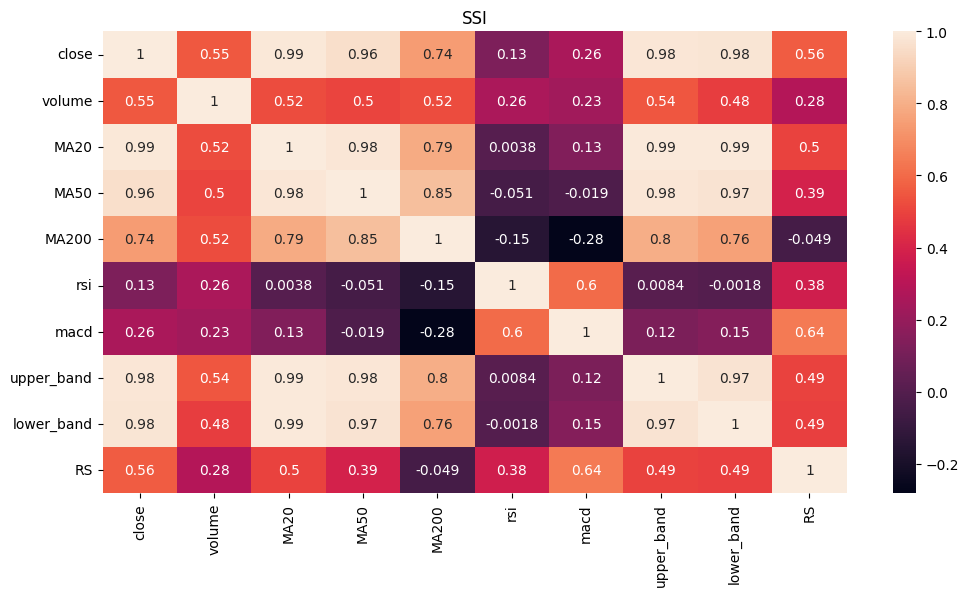

In [12]:
data_model = []

for i, data in enumerate(data_indi): 
    try:
        # remove name

        data = data.drop("time", axis=1)
        data = data.reset_index(drop=True)
        data = data.drop("ticker", axis=1)
        data = data.drop("industry", axis=1)

        # remove feature that have too high correlation

        data = data.drop("open", axis=1)
        data = data.drop("high", axis=1)
        data = data.drop("low", axis=1)
        data = data.drop("MA10", axis=1)

        # remove uncount data

        data.drop(data.tail((len(data.index) - 126) % 21).index, inplace=True)
                
        data = data.reset_index(drop=True)
        

    except Exception as e:
        print()

    data_model.append(data)



# plot data

plt.figure(figsize=(12, 6))
plt.title(code_ticker_taken[0])
corrMatrix = data_model[0].corr()
sns.heatmap(corrMatrix, annot=True)

In [13]:
data_model[0].shape

(1239, 10)

Split Data

In [14]:
# split train and test data

train_day = 21 * 6  # 6 month
test_day = 21  # 1 month
num_set = (len(data.index) - 126) // 21  # num of dataset


sum_train = []
sum_test = []

for data in data_model:
    train_set = []
    test_set = []
    for i in range(num_set):
        set_train = data.iloc[test_day * i : train_day + test_day * i]
        set_test = data.iloc[train_day + test_day * i : train_day + test_day * (i + 1)]
        train_set.append(set_train)
        test_set.append(set_test)
    sum_train.append(train_set)
    sum_test.append(test_set)

In [15]:
sum_train[0][52]
# sum_train[1][52]['close']

,close,volume,MA20,MA50,MA200,rsi,macd,upper_band,lower_band,RS
1092,18330,15079900,18571.5,18644.8,19226.795,47.570850,-1.049506,19858.262972,17284.737028,-9.618439
1093,19580,28458900,18631.5,18686.2,19194.745,55.421687,77.673880,19990.544169,17272.455831,-3.964324
1094,19390,19590700,18663.0,18724.8,19162.795,60.412758,123.309879,20063.166907,17262.833093,-5.656723
1095,19530,19301900,18704.0,18776.8,19131.995,70.736842,168.827429,20156.988209,17251.011791,-5.103508
1096,18760,18548100,18644.0,18811.4,19099.745,60.869565,141.140867,19972.369004,17315.630996,-6.411020
...,...,...,...,...,...,...,...,...,...,...
1213,34000,19656200,30605.0,29024.0,22289.750,77.319588,1403.784235,34772.025949,26437.974051,60.212595
1214,33650,21471400,30832.5,29165.0,22382.000,74.242424,1419.794796,35147.745312,26517.254688,58.374080
1215,33750,16656500,31090.0,29309.0,22472.600,71.348315,1424.135892,35458.620160,26721.379840,58.295248
1216,33500,34427300,31360.0,29470.0,22562.650,84.666667,1391.364548,35616.586228,27103.413772,59.589431


# Model

Linear Regression

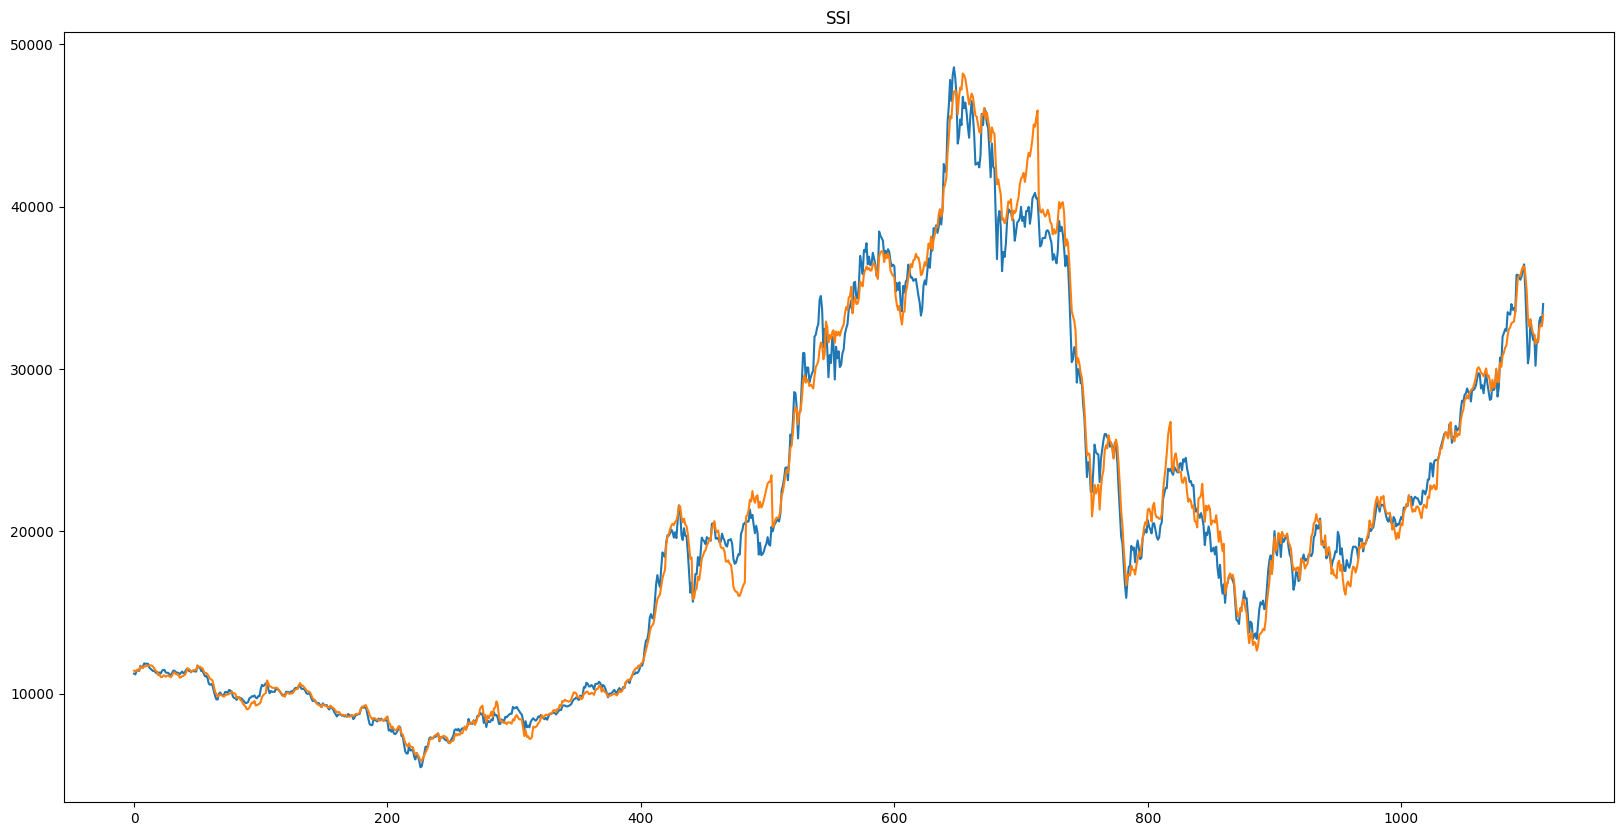

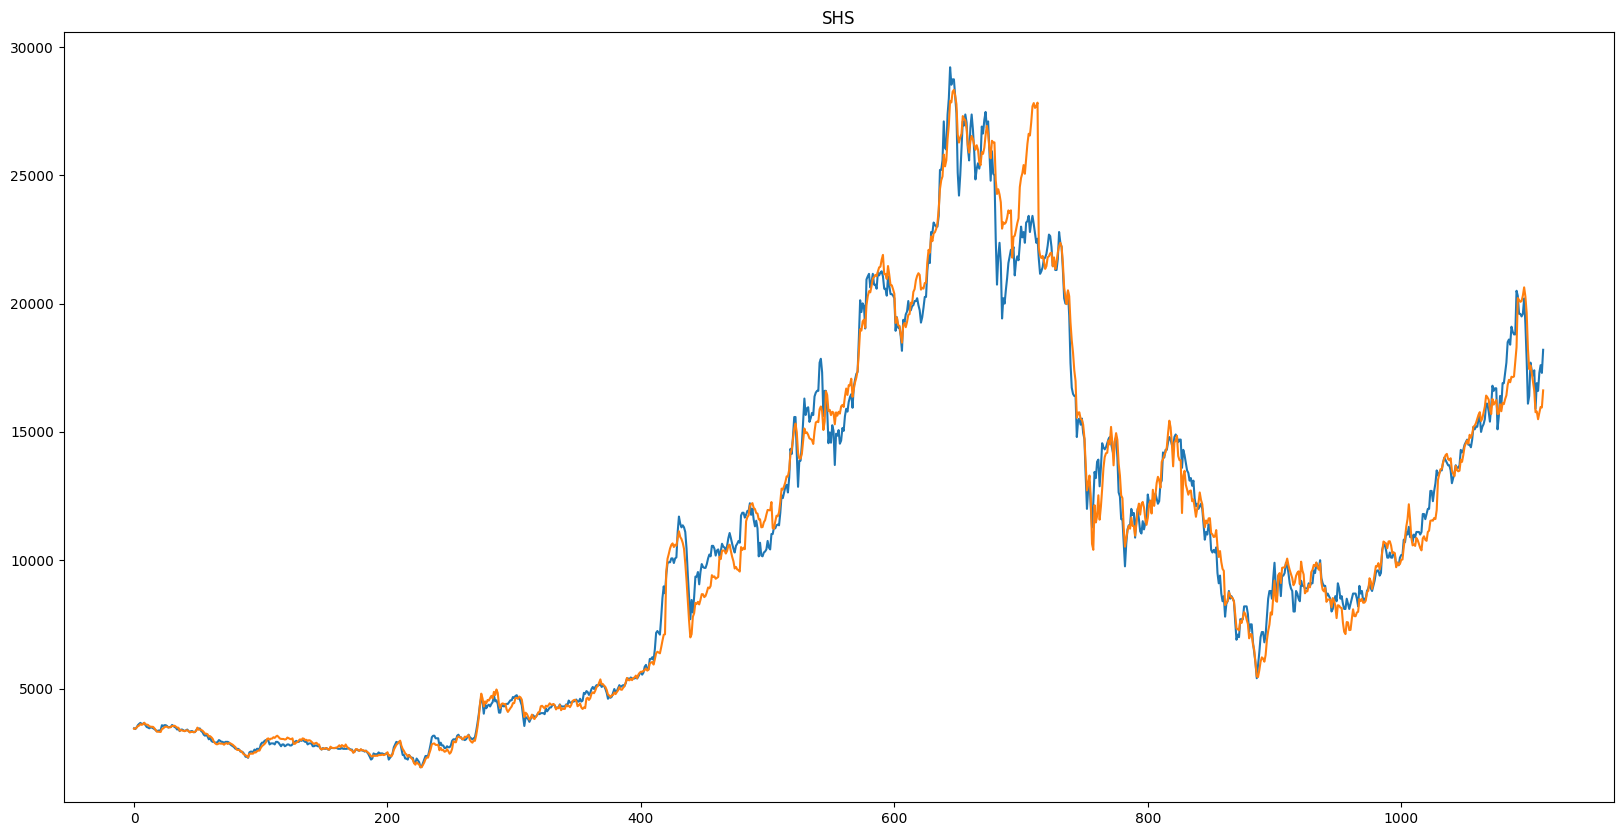

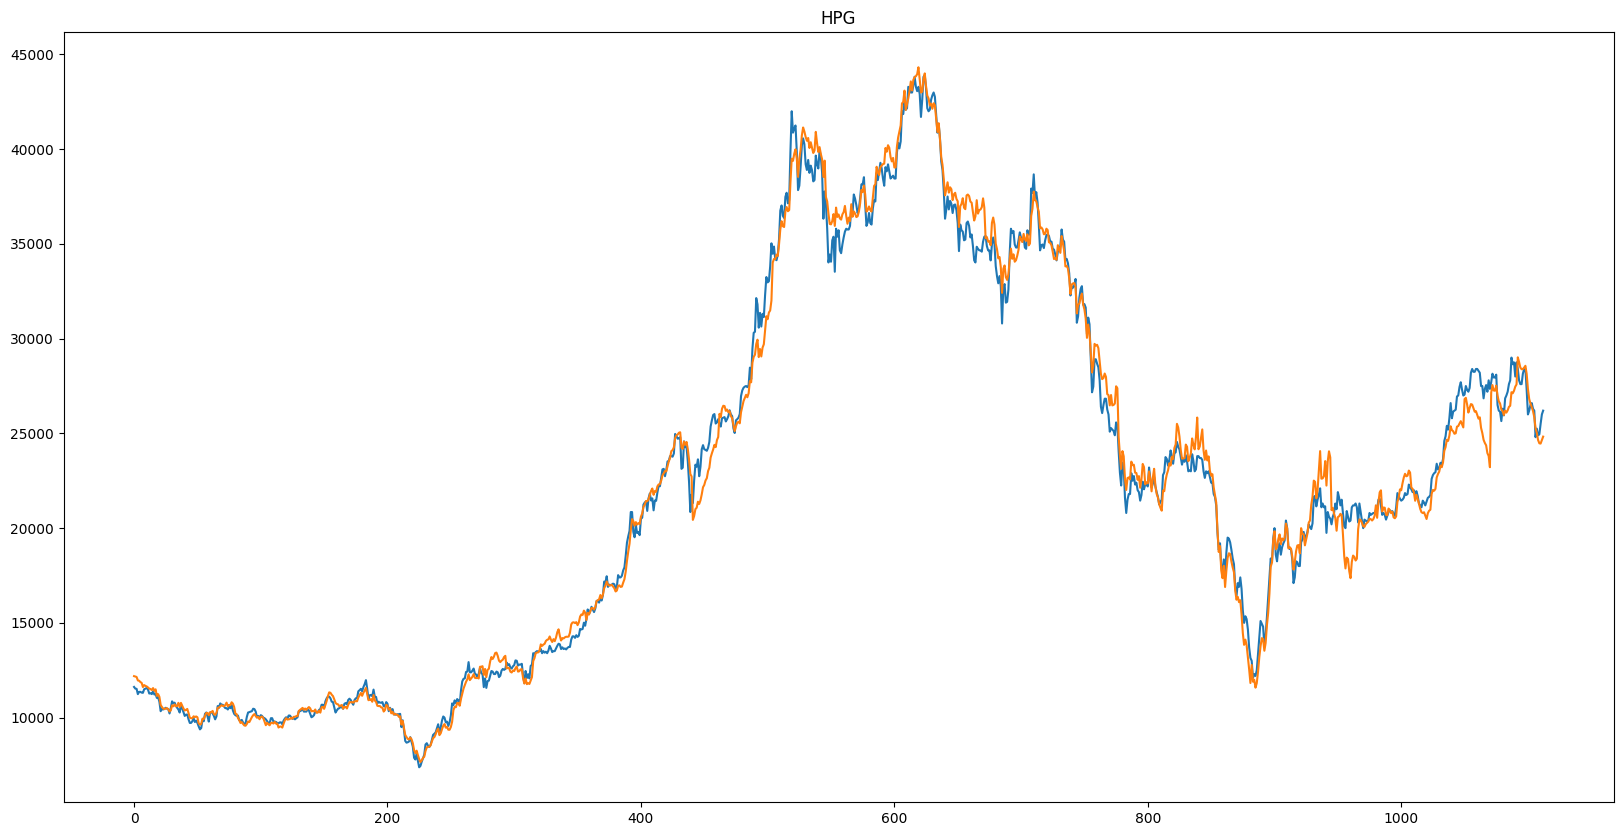

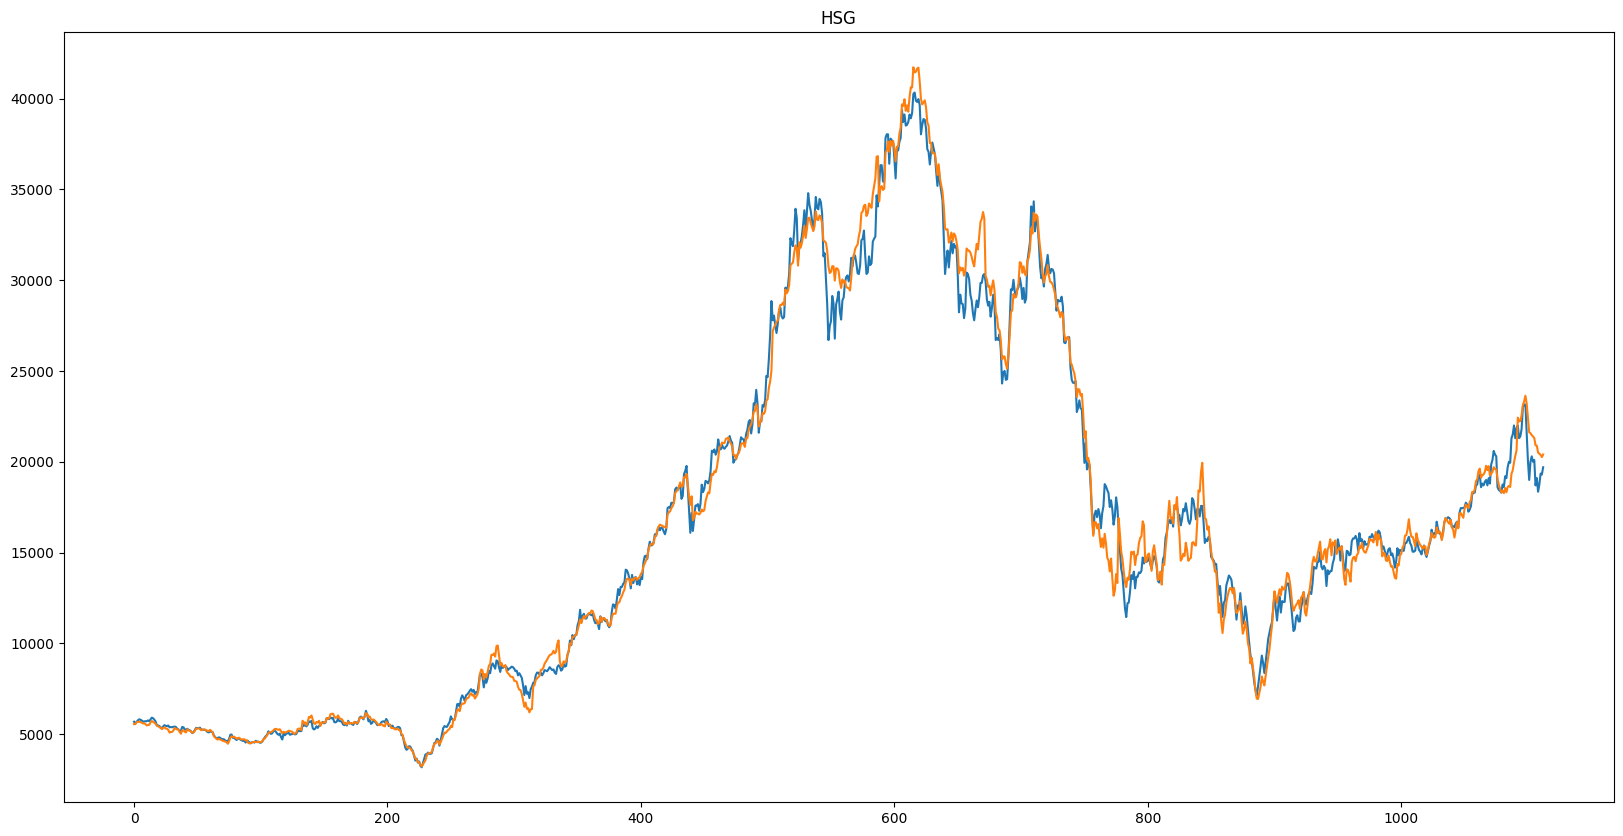

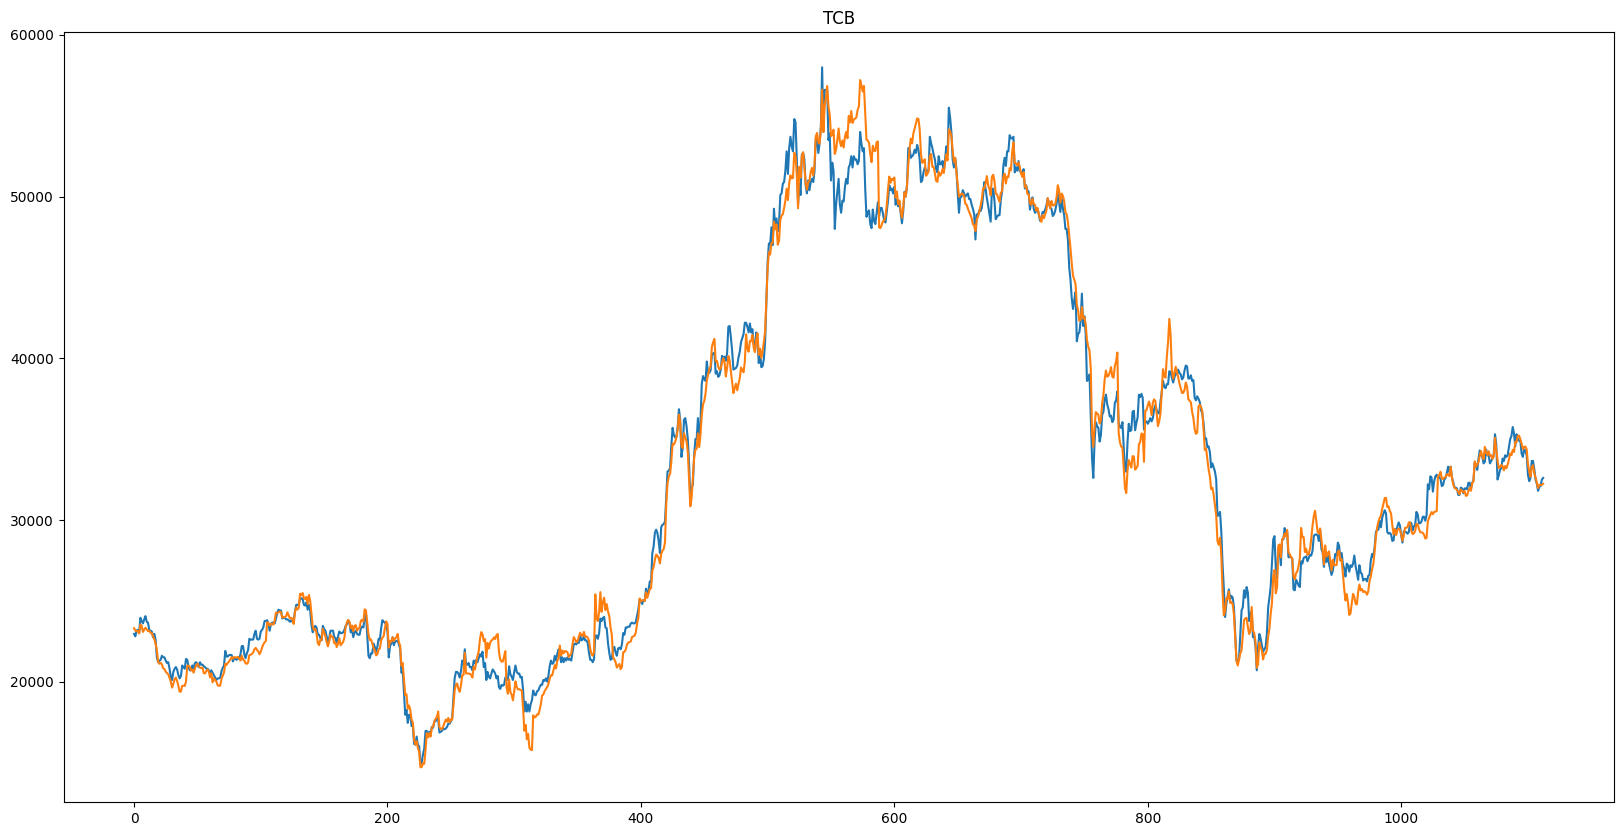

In [16]:
pred_y_LR = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):
        Y_train = sum_train[i][j]['close'].to_numpy()
        X_train = sum_train[i][j].drop('close', axis=1).to_numpy()
        y_test = sum_test[i][j]['close']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop('close', axis=1).to_numpy()
        model = LinearRegression().fit(X_train, Y_train)
        y_pred = model.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y_LR.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual')
    plt.plot(y_pred_all, label='Predict')
    plt.title(code_ticker_taken[i])    

Random Forest

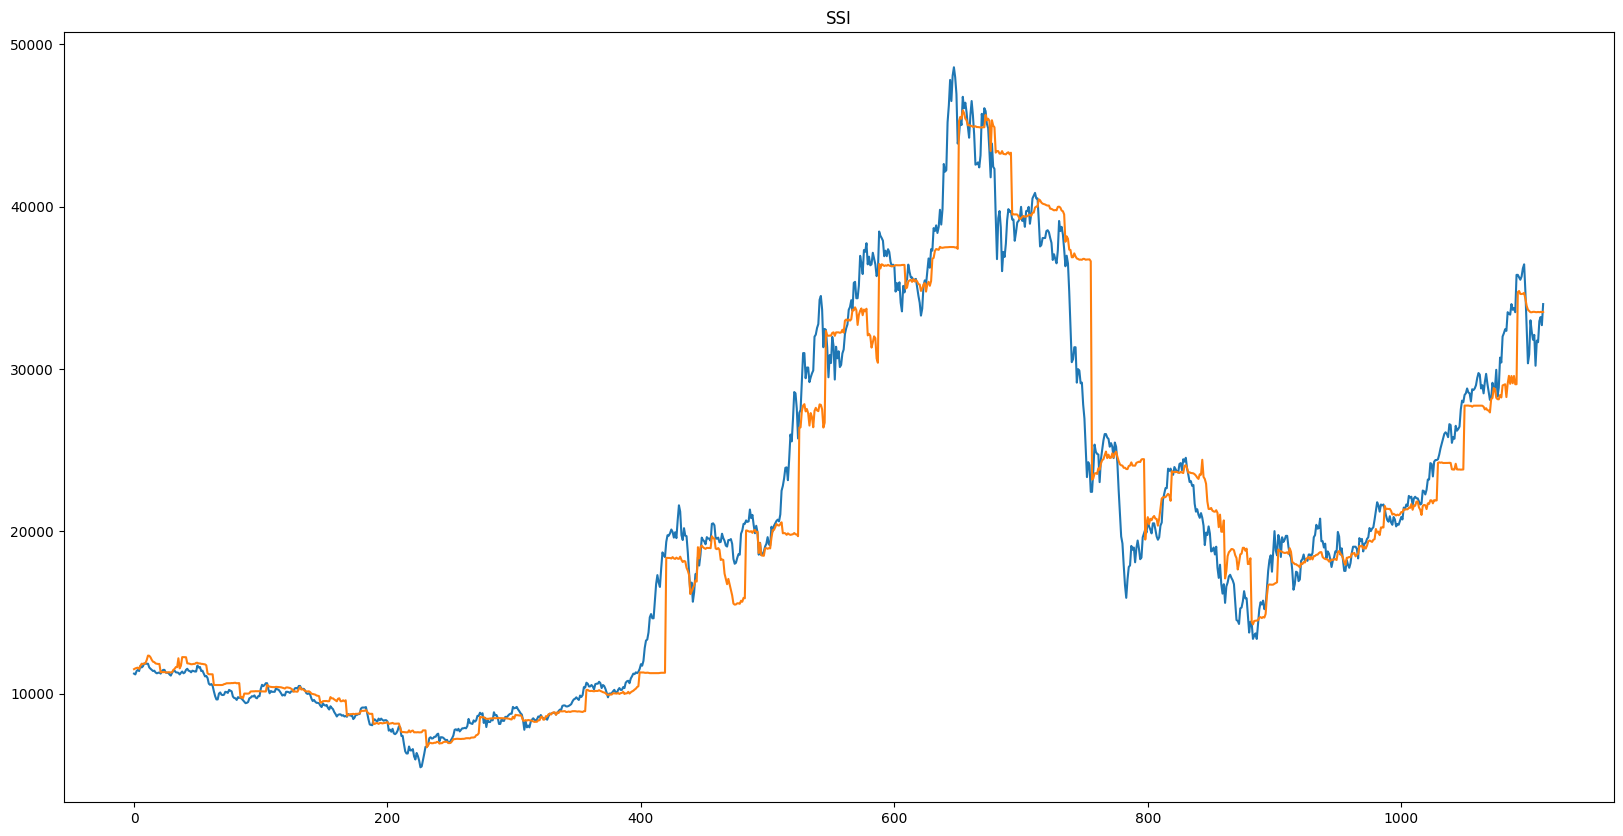

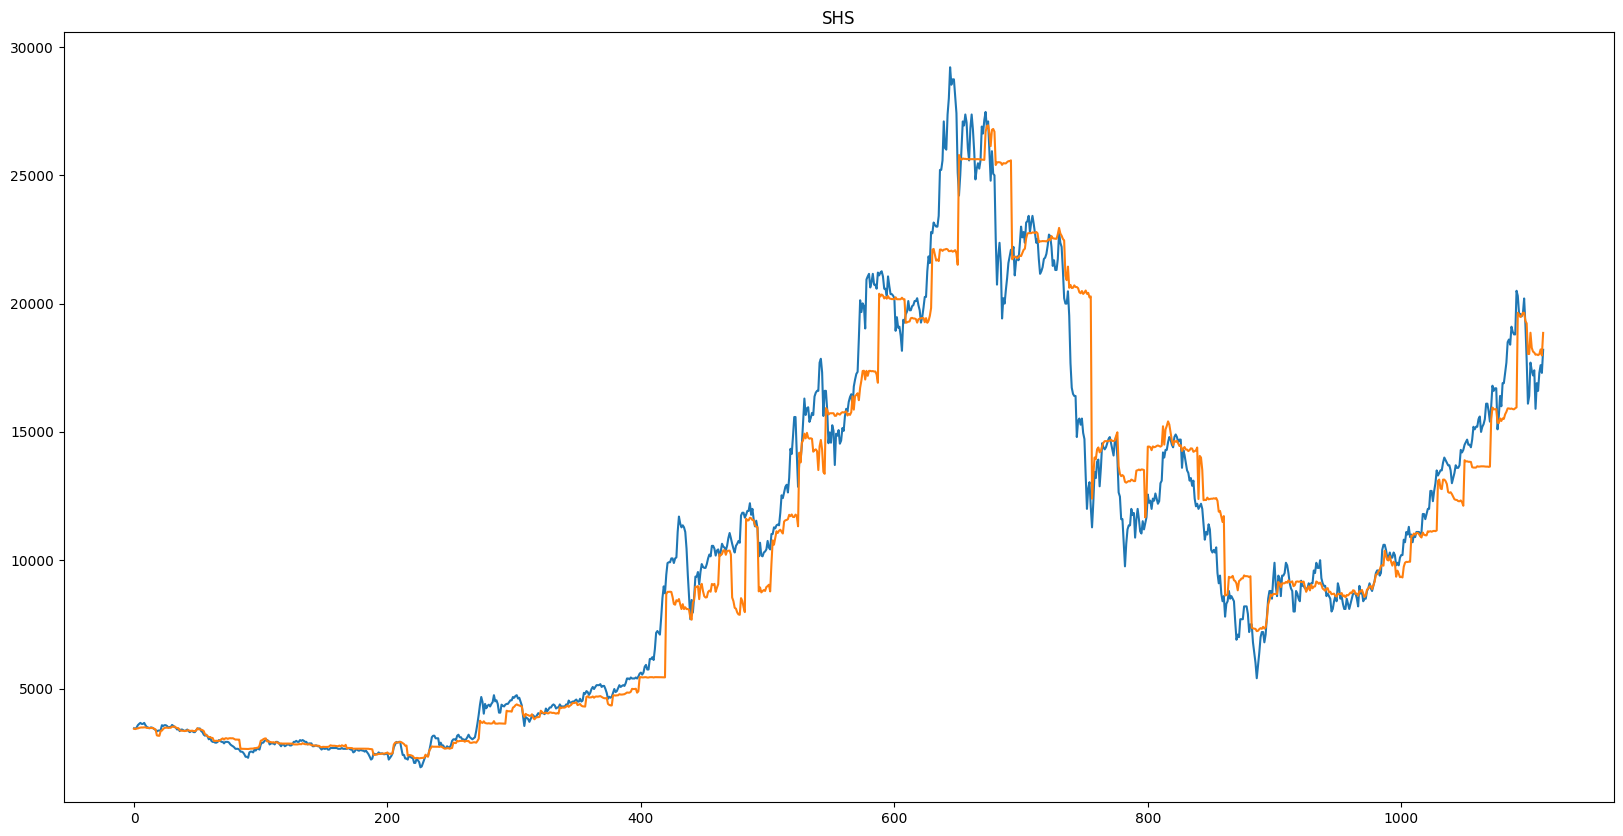

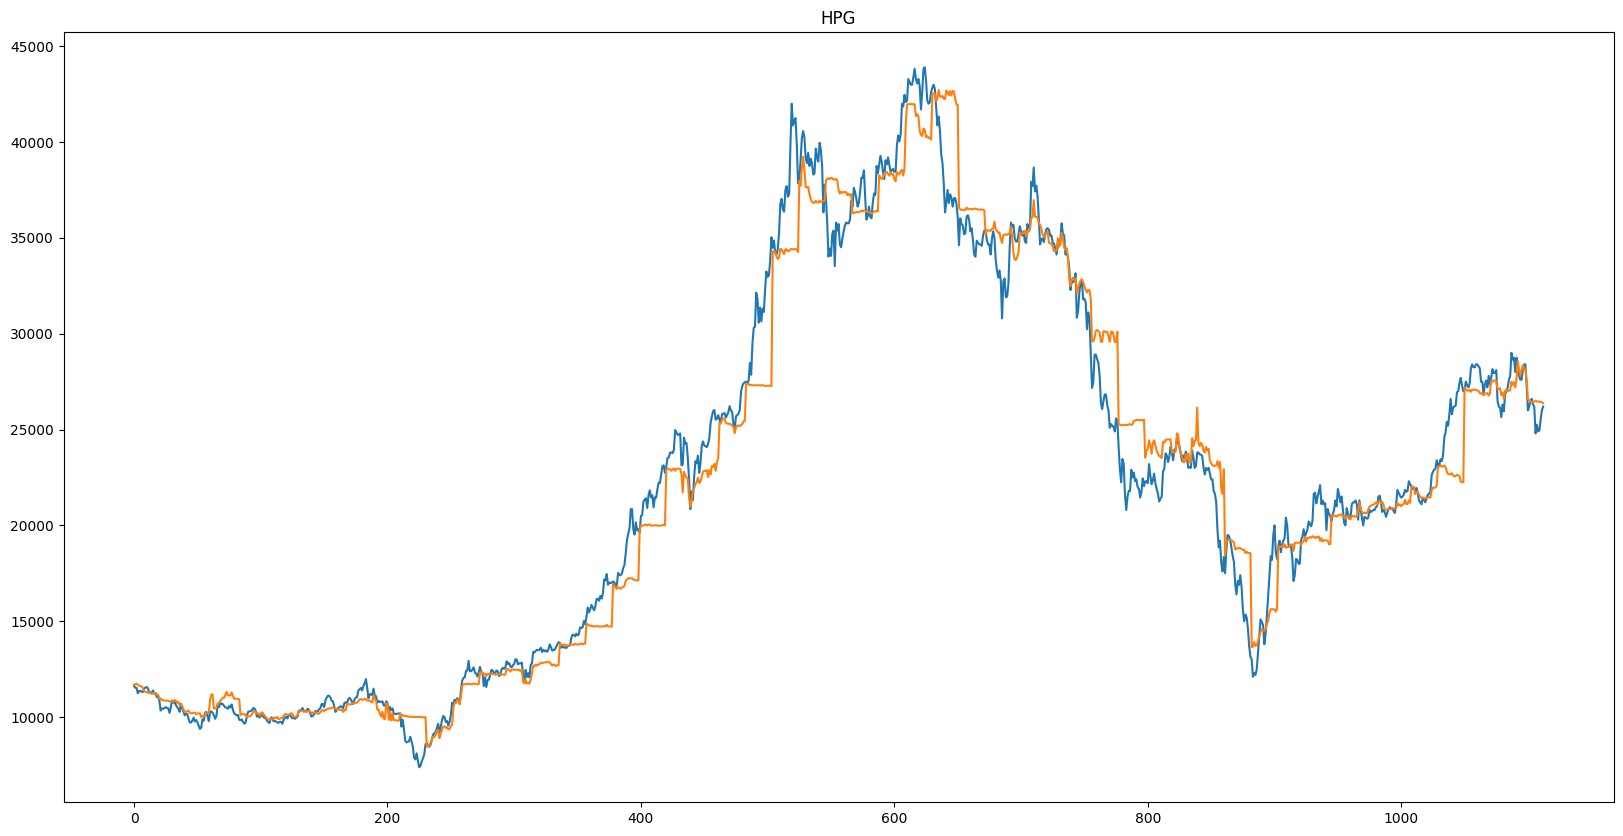

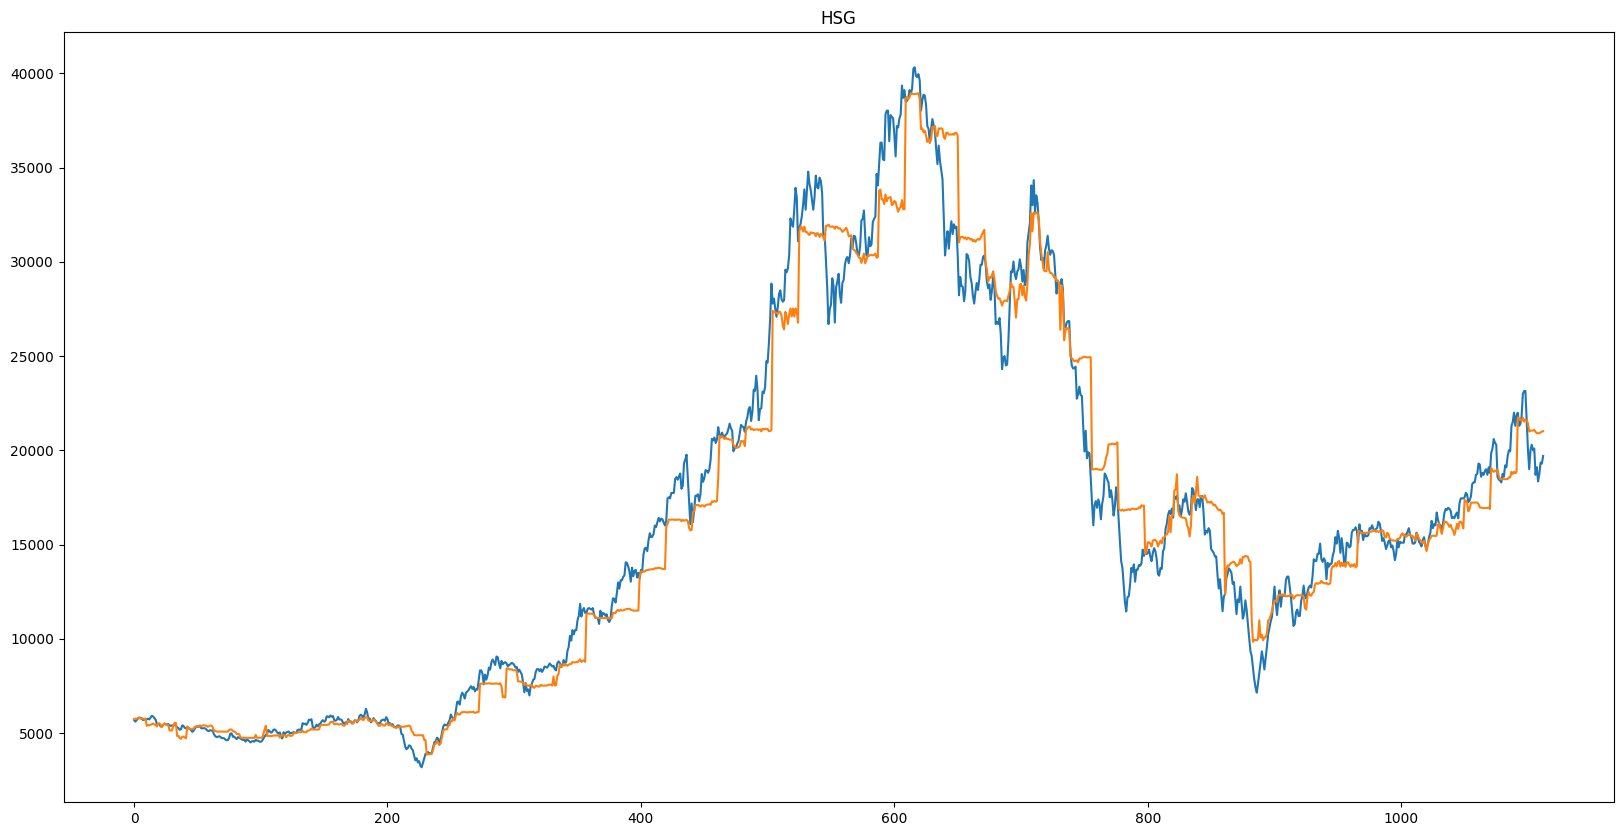

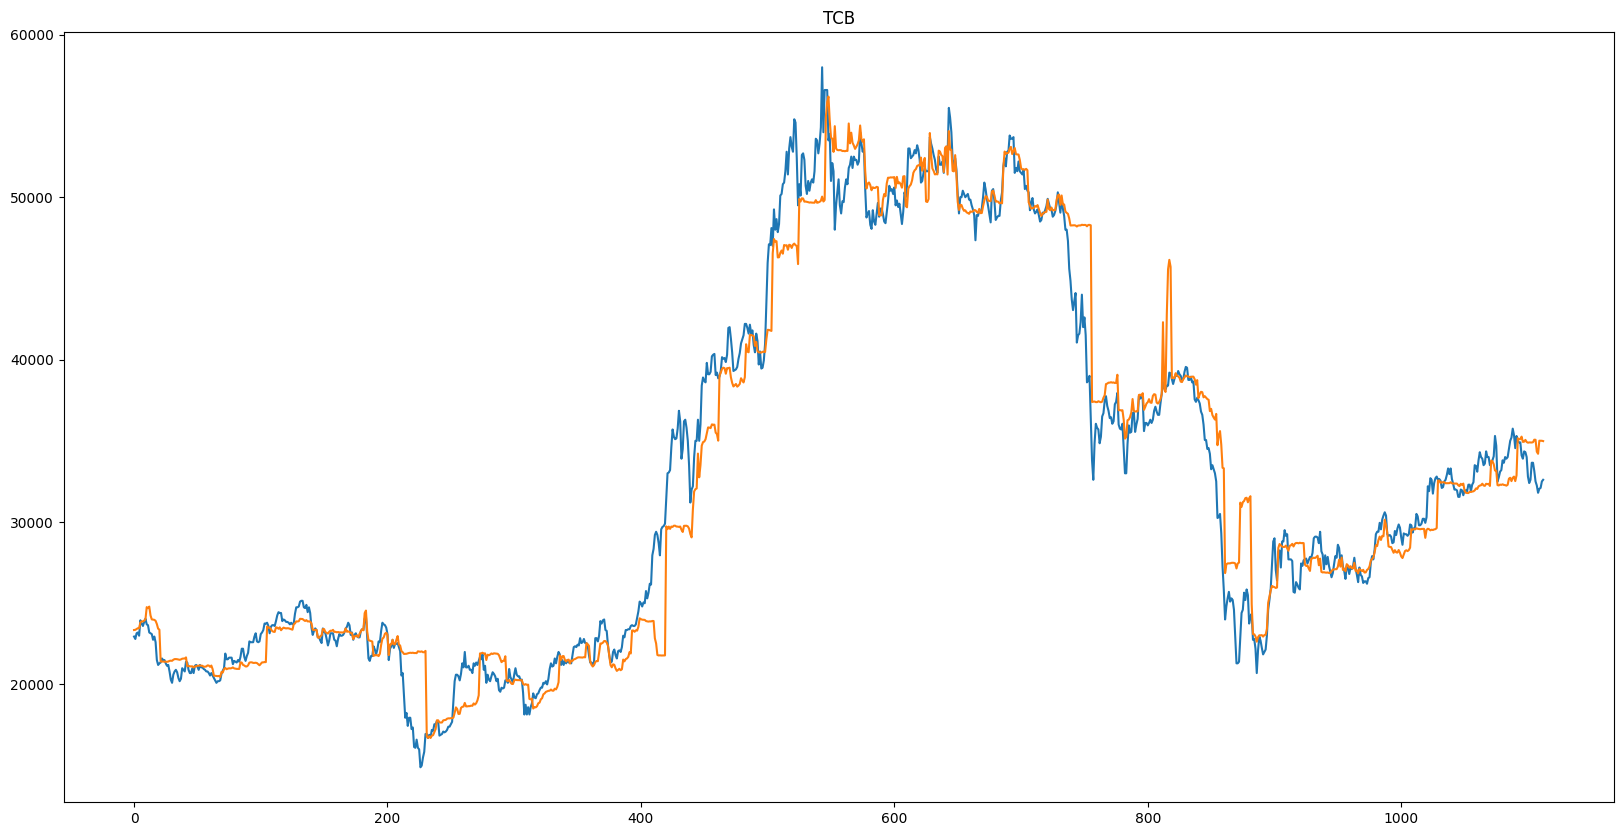

In [39]:
pred_y_RF = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):
        Y_train = sum_train[i][j]['close'].to_numpy()
        X_train = sum_train[i][j].drop('close', axis=1).to_numpy()
        y_test = sum_test[i][j]['close']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop('close', axis=1).to_numpy()
        regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
        regressor.fit(X_train, Y_train)
        y_pred = regressor.predict(x_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y_RF.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual')
    plt.plot(y_pred_all, label='Predict')
    plt.title(code_ticker_taken[i])  

LSTM

In [ ]:
# split train and test data

train_day = 21 * 6  # 6 month
test_day = 21  # 1 month
num_set = (len(data.index) - 126) // 21  # num of dataset


sum_train = []
sum_test = []

for data in data_model:
    train_set = []
    test_set = []
    for i in range(num_set):
        set_train = data.iloc[test_day * i : train_day + test_day * i]
        set_test = data.iloc[train_day + test_day * i : train_day + test_day * (i + 1)]
        train_set.append(set_train)
        test_set.append(set_test)
    sum_train.append(train_set)
    sum_test.append(test_set)

In [99]:
sum_train[0][1]

,close,volume,MA20,MA50,MA200,rsi,macd,upper_band,lower_band,RS
21,12710,1626230,12848.5,12775.0,11981.8,44.394619,43.712979,13246.086138,12450.913862,-11.661495
22,12820,1561150,12838.0,12775.0,11981.8,45.374449,42.980337,13226.389387,12449.610613,-11.661495
23,12860,2115370,12844.5,12775.0,11981.8,55.729167,45.107409,13229.616524,12459.383476,-11.661495
24,12960,1080940,12838.0,12775.0,11981.8,52.777778,54.237082,13209.829050,12466.170950,-11.661495
25,13480,3666920,12855.5,12775.0,11981.8,69.339623,102.253354,13309.139087,12401.860913,-11.661495
...,...,...,...,...,...,...,...,...,...,...
142,11410,775200,11549.0,11983.4,11981.8,50.769231,-113.979933,11976.718550,11121.281450,-11.661495
143,11300,991780,11525.0,11943.8,11981.8,44.029851,-126.772697,11952.009183,11097.990817,-11.661495
144,11250,1180930,11514.5,11906.2,11981.8,44.696970,-139.339419,11958.238899,11070.761101,-11.661495
145,11280,694920,11513.0,11872.2,11981.8,29.126214,-145.204065,11959.841547,11066.158453,-11.661495


In [82]:
scaler = MinMaxScaler()
target = data_model[0]['close']
features = scaler.fit_transform(data_model[0].drop('close',axis=1))
target = scaler.fit_transform(target.values.reshape(-1, 1))

In [83]:
train_size = int(len(data) * 0.8)
X_train, y_train = features[:train_size], target[:train_size]
X_test, y_test = features[train_size:], target[train_size:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [93]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, return_sequences=False))
# model.add(Dense(30))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [94]:
hist = model.fit(X_train, y_train, epochs=50, batch_size=8)

Epoch 1/50


124/124 [==============================] - 3s 8ms/step - loss: 0.0237
Epoch 2/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 3/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0019
Epoch 4/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 5/50
124/124 [==============================] - 1s 10ms/step - loss: 0.0015
Epoch 6/50
124/124 [==============================] - 1s 10ms/step - loss: 0.0015
Epoch 7/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 8/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0013
Epoch 9/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0012
Epoch 10/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 11/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 12/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 13/50
124/124 [=============

In [95]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 1s 4ms/step


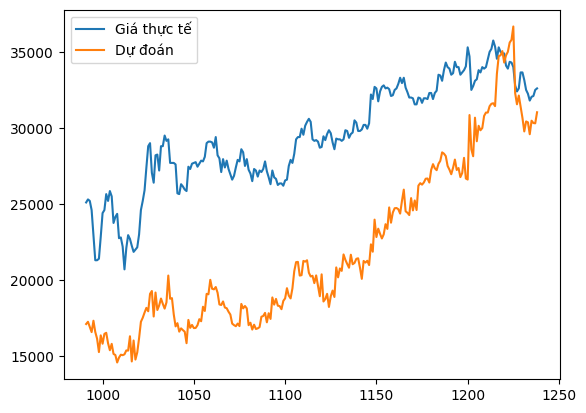

In [96]:
import matplotlib.pyplot as plt
plt.plot(data.index[train_size:], data['close'][train_size:], label='Giá thực tế')
plt.plot(data.index[train_size:], predicted_prices, label='Dự đoán')
plt.legend()
plt.show()

Ensemble: Average between LR - RF

887.2003107882264
537.9600130762557
702.4639828274238
673.9658646415384
933.6151741575721


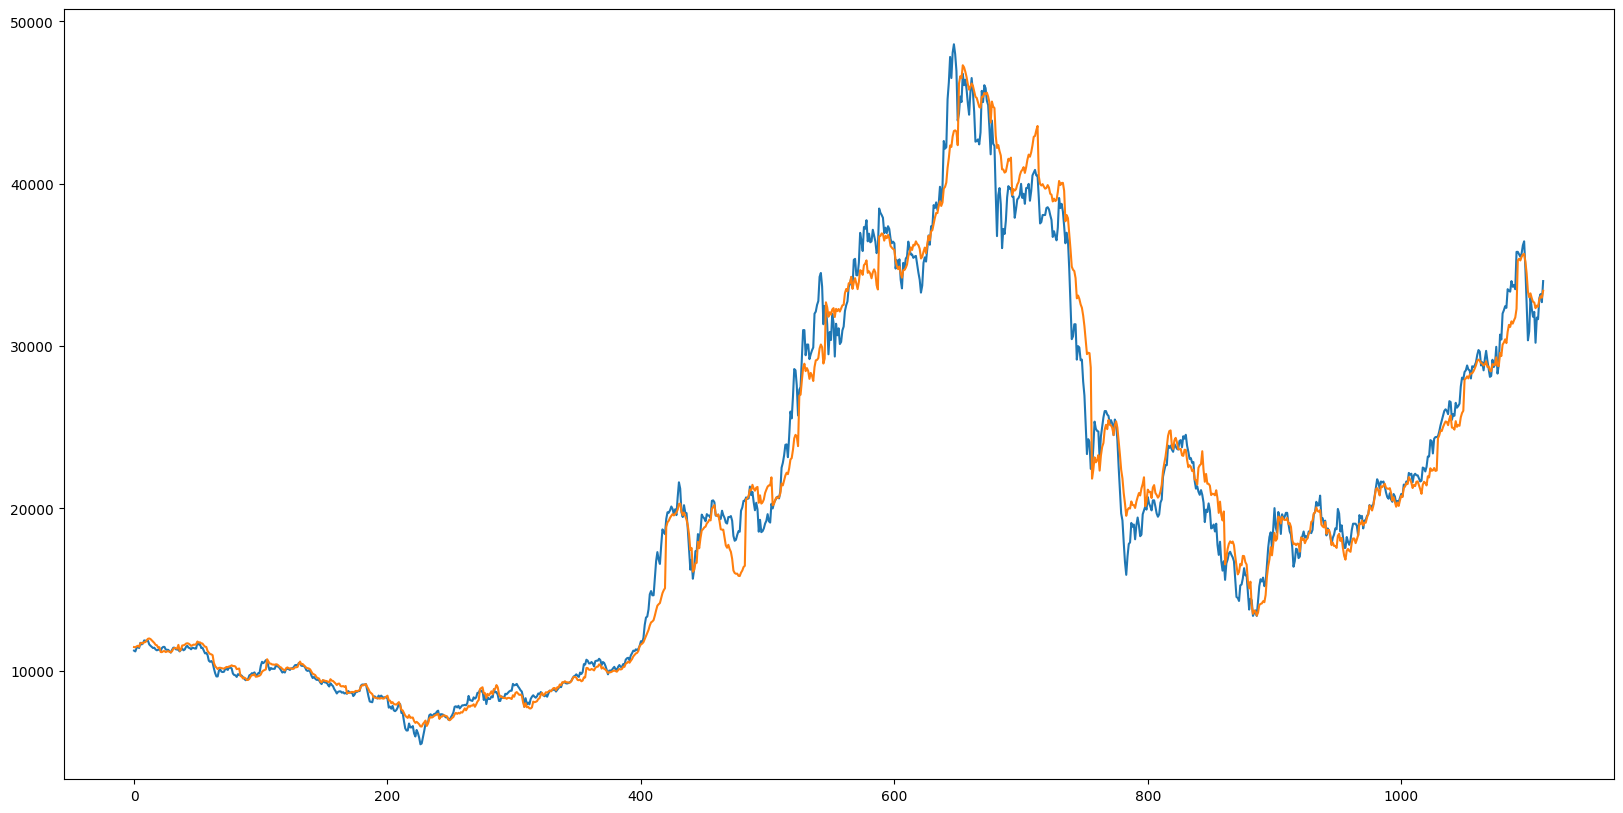

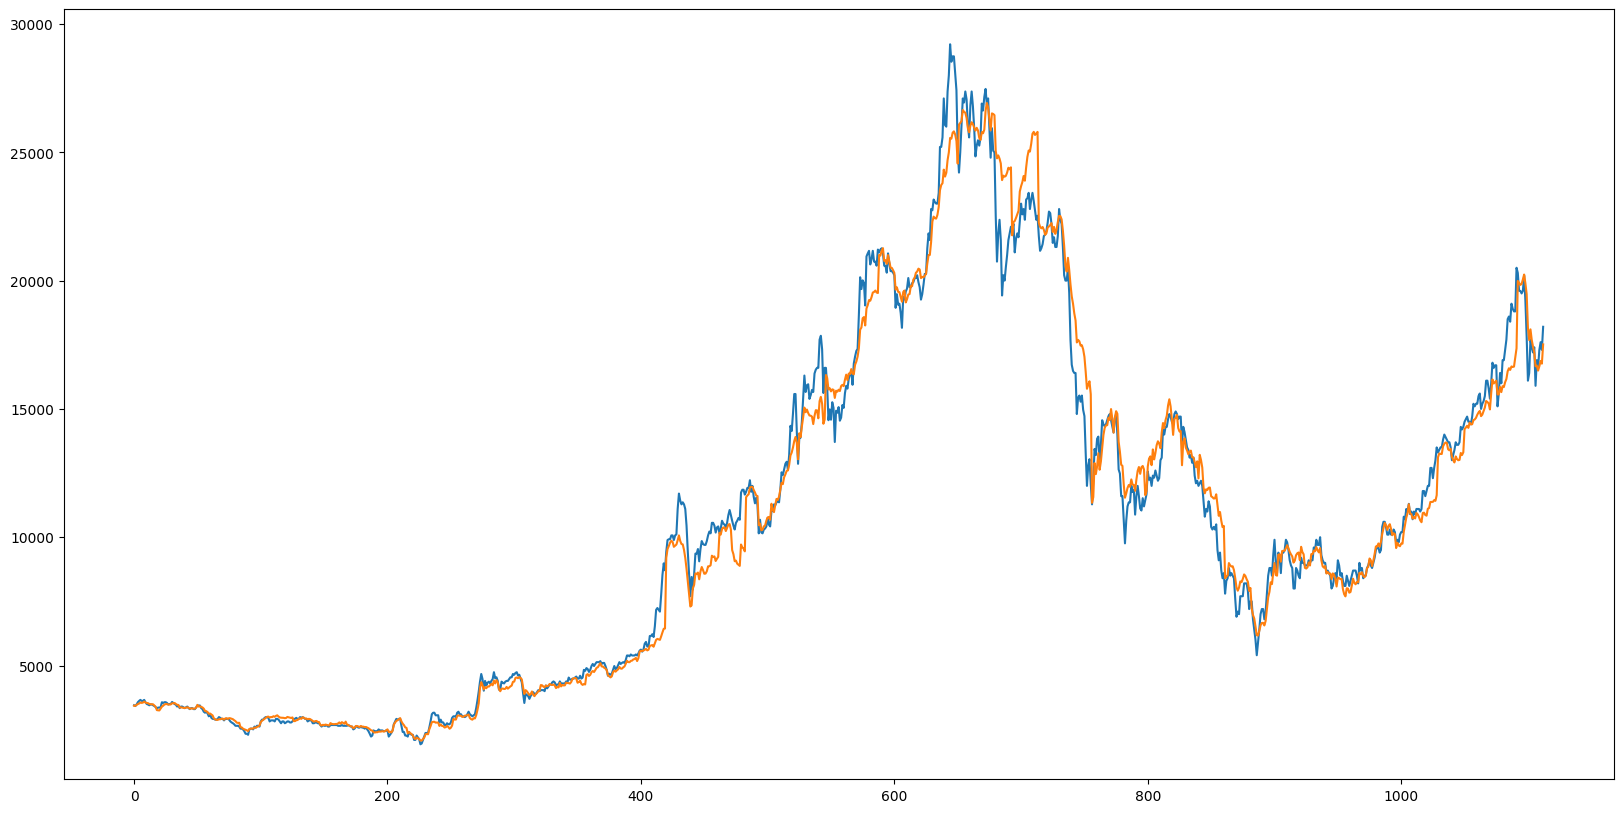

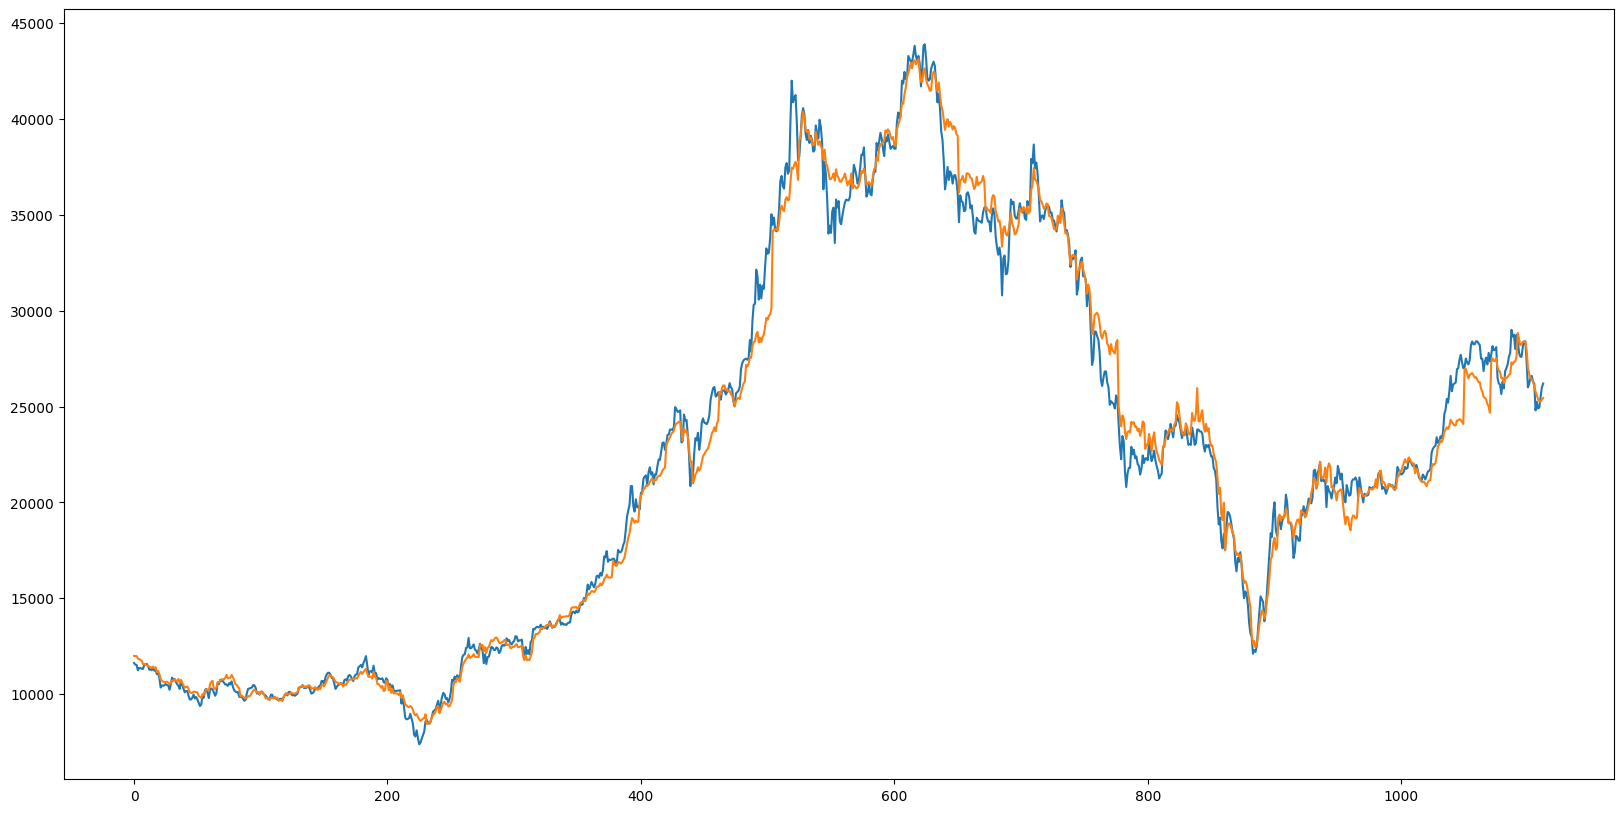

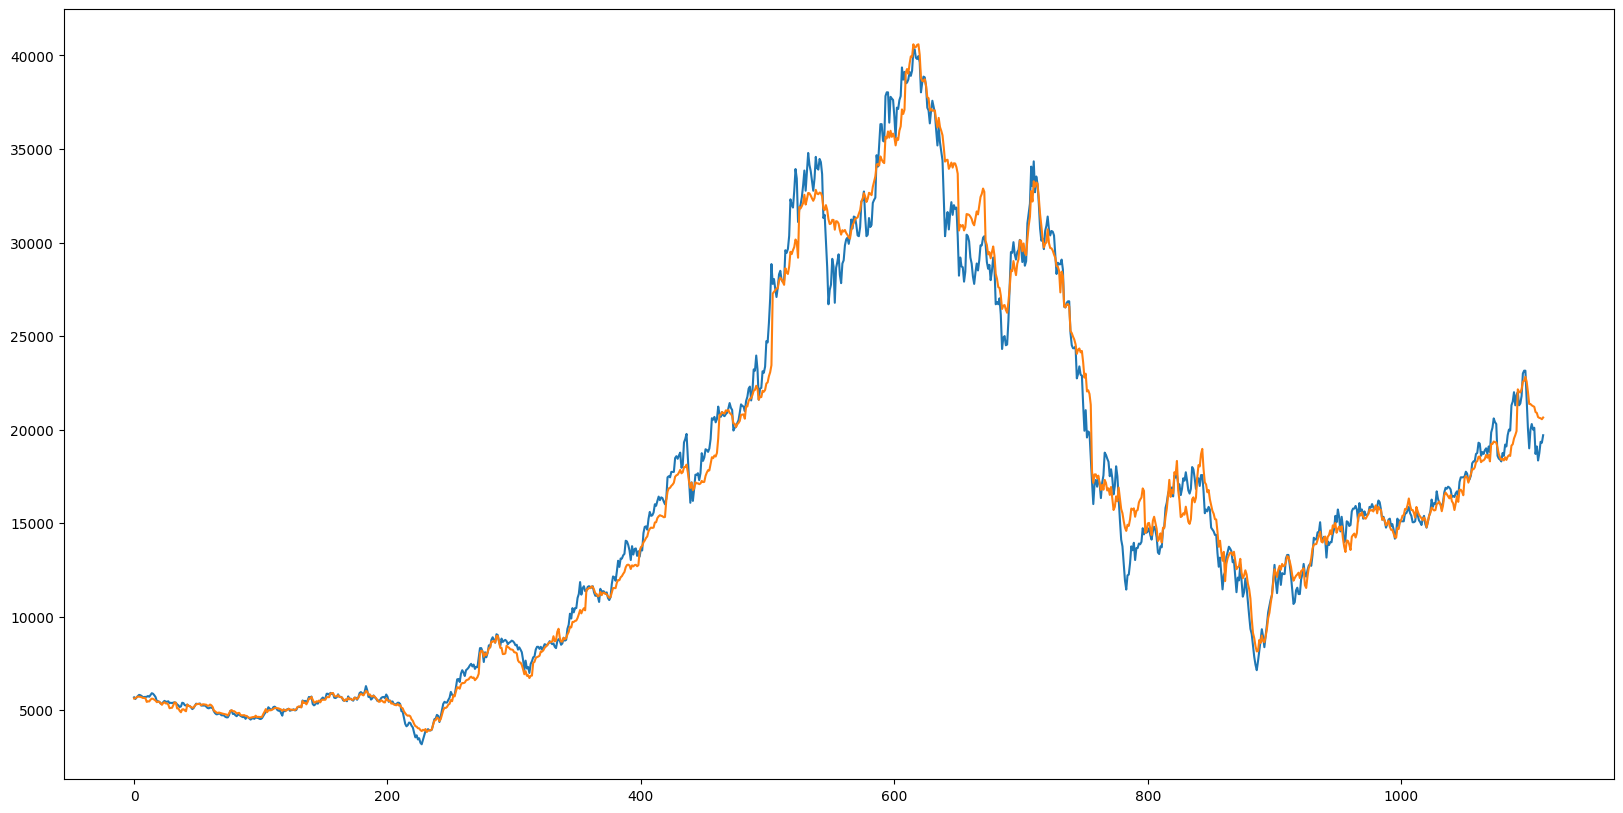

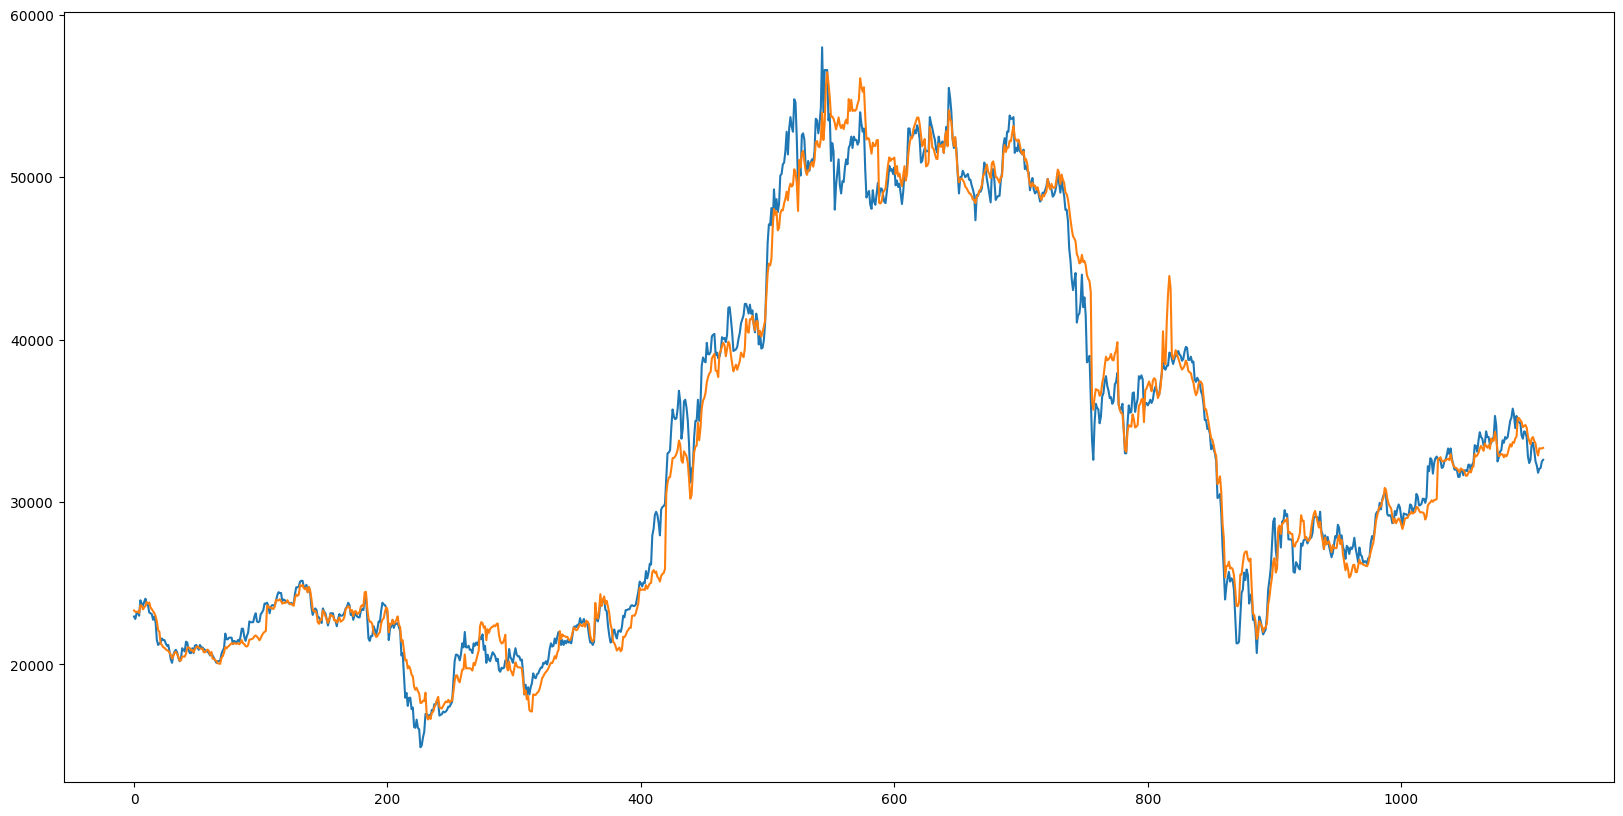

In [90]:
pred_y_LR_RF =[]

for pred_LR,pred_RF,test in zip(pred_y_LR,pred_y_RF,test_y):
    size = 0.6
    new_pred = size*pred_LR+(1-size)*pred_RF
    pred_y_LR_RF.append(new_pred)
    plt.figure(figsize=(20, 10))
    plt.plot(test, label='Actual')
    plt.plot(new_pred, label='Predict')
    mae = mean_absolute_error(test, new_pred)
    rmse = np.sqrt(mean_squared_error(test, new_pred))
    print(mae)
    # print(rmse)


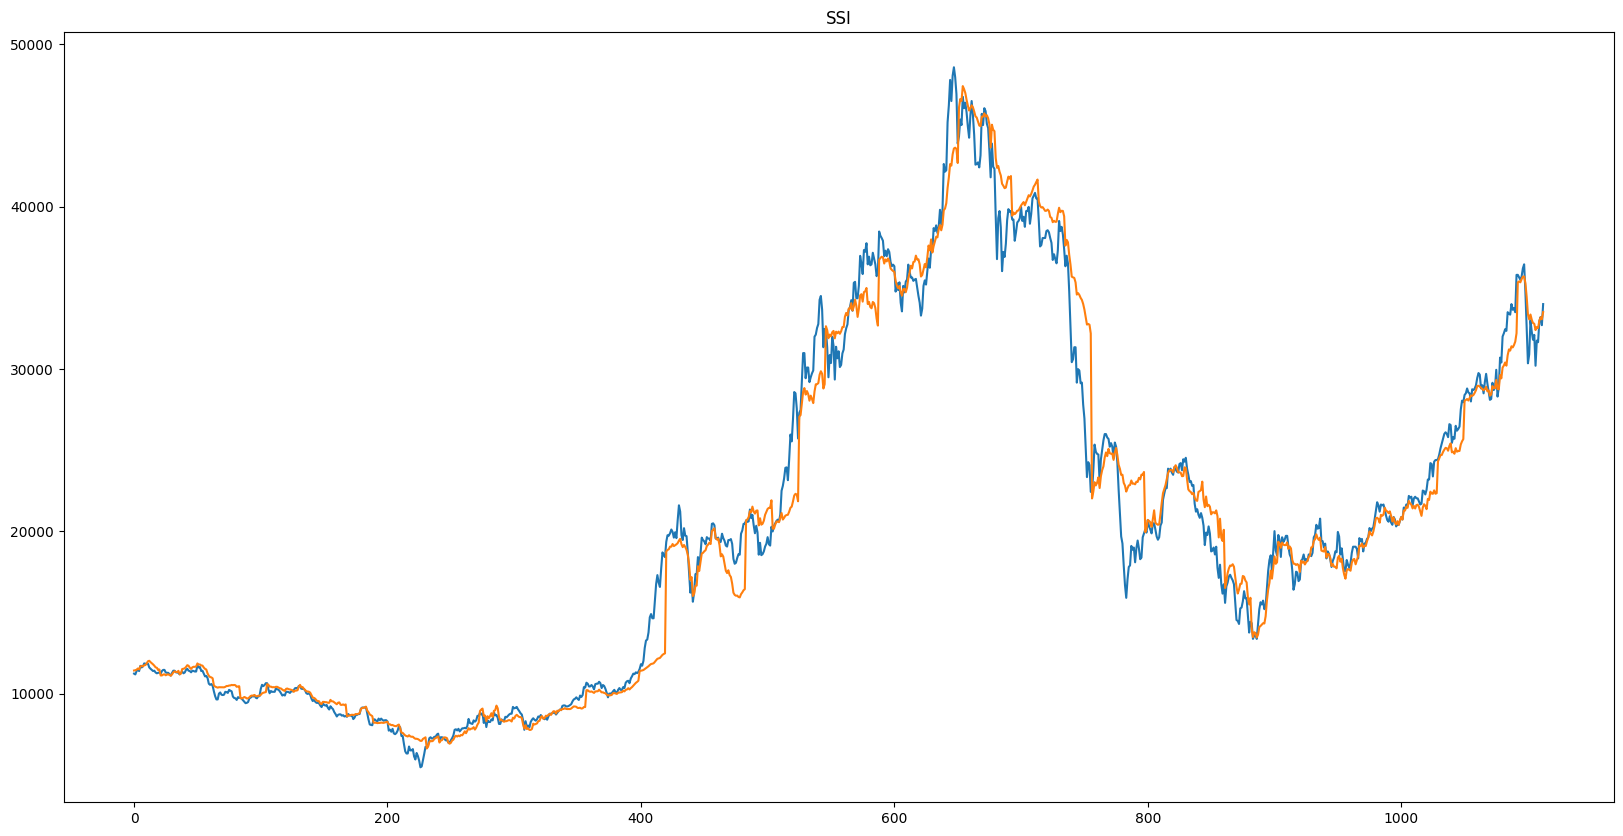

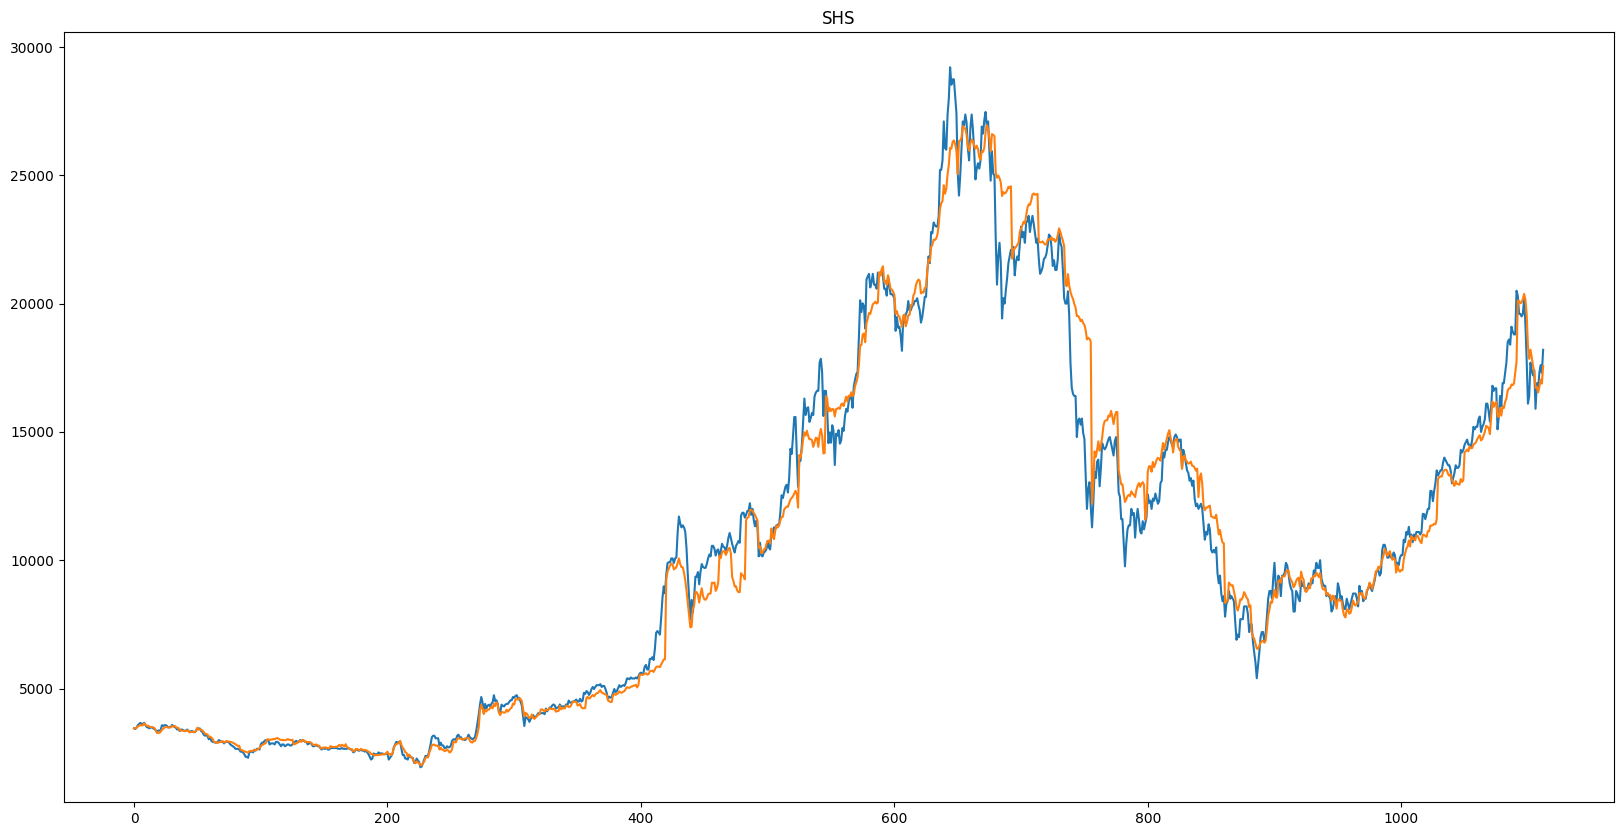

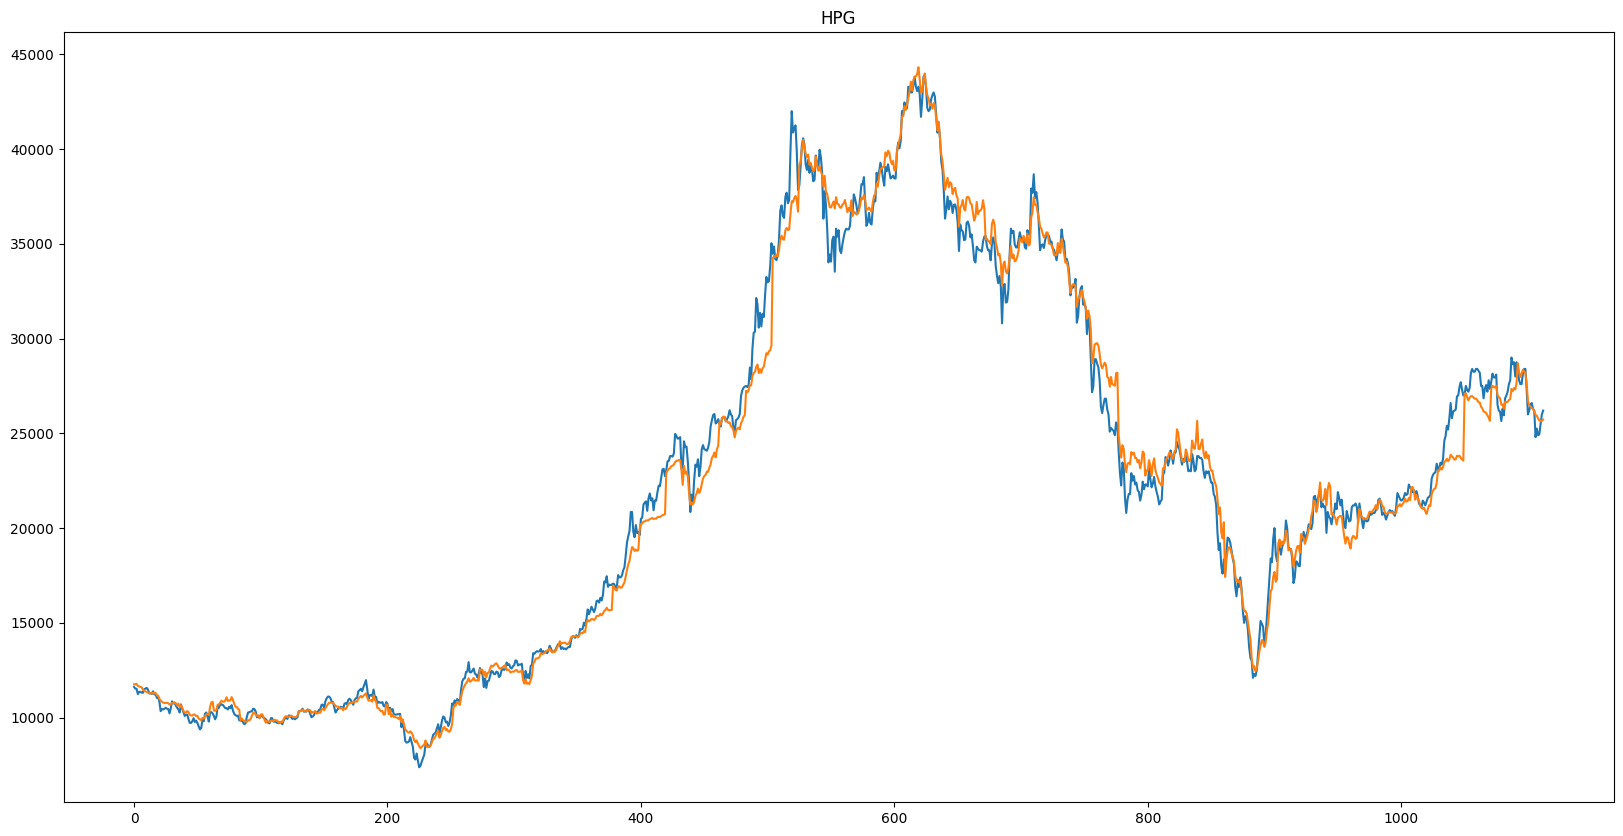

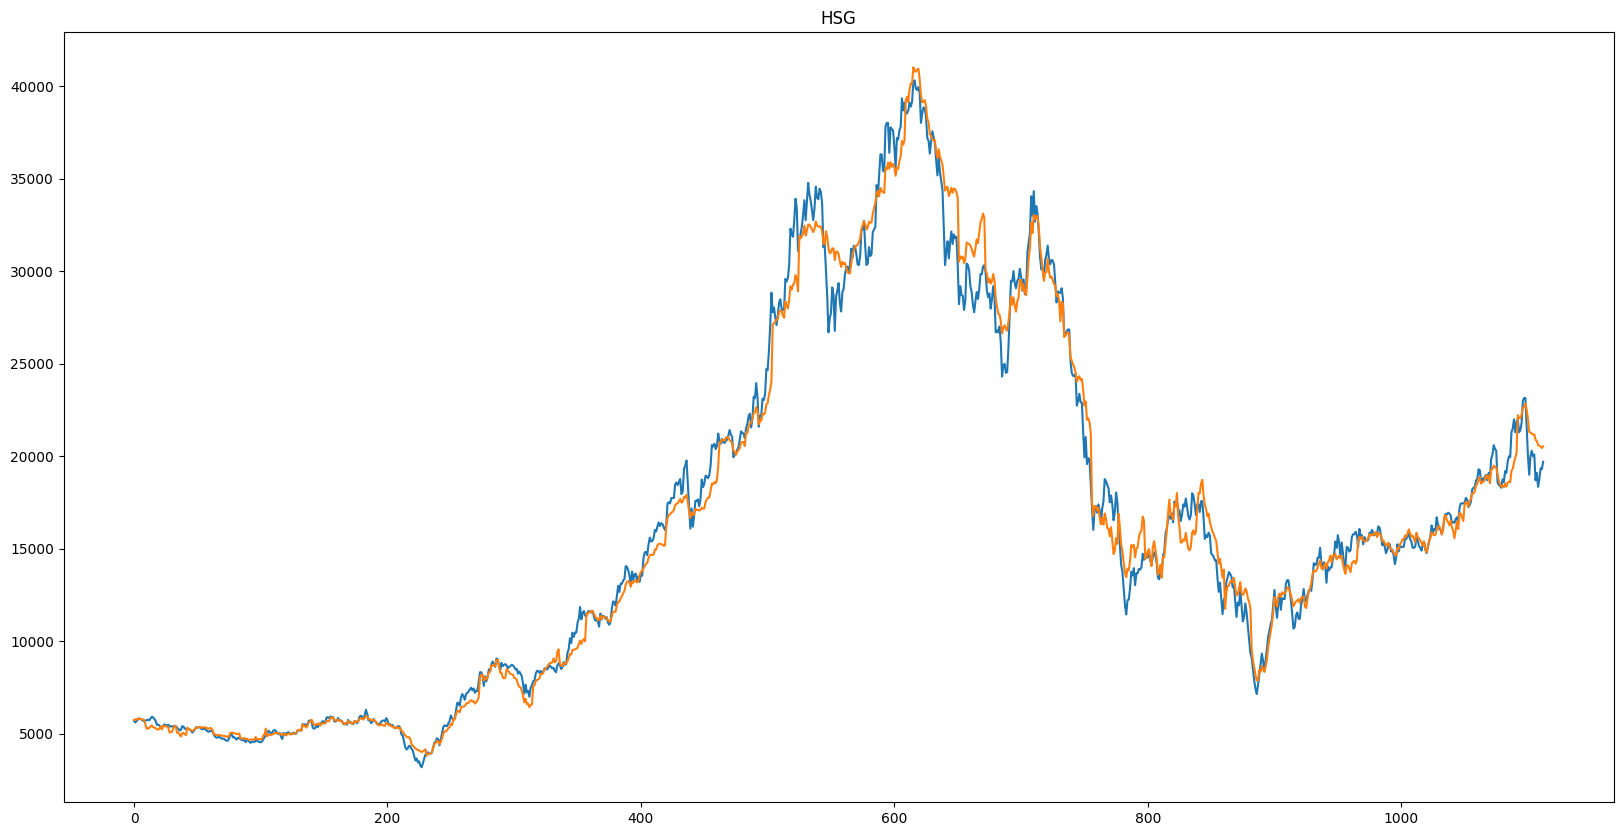

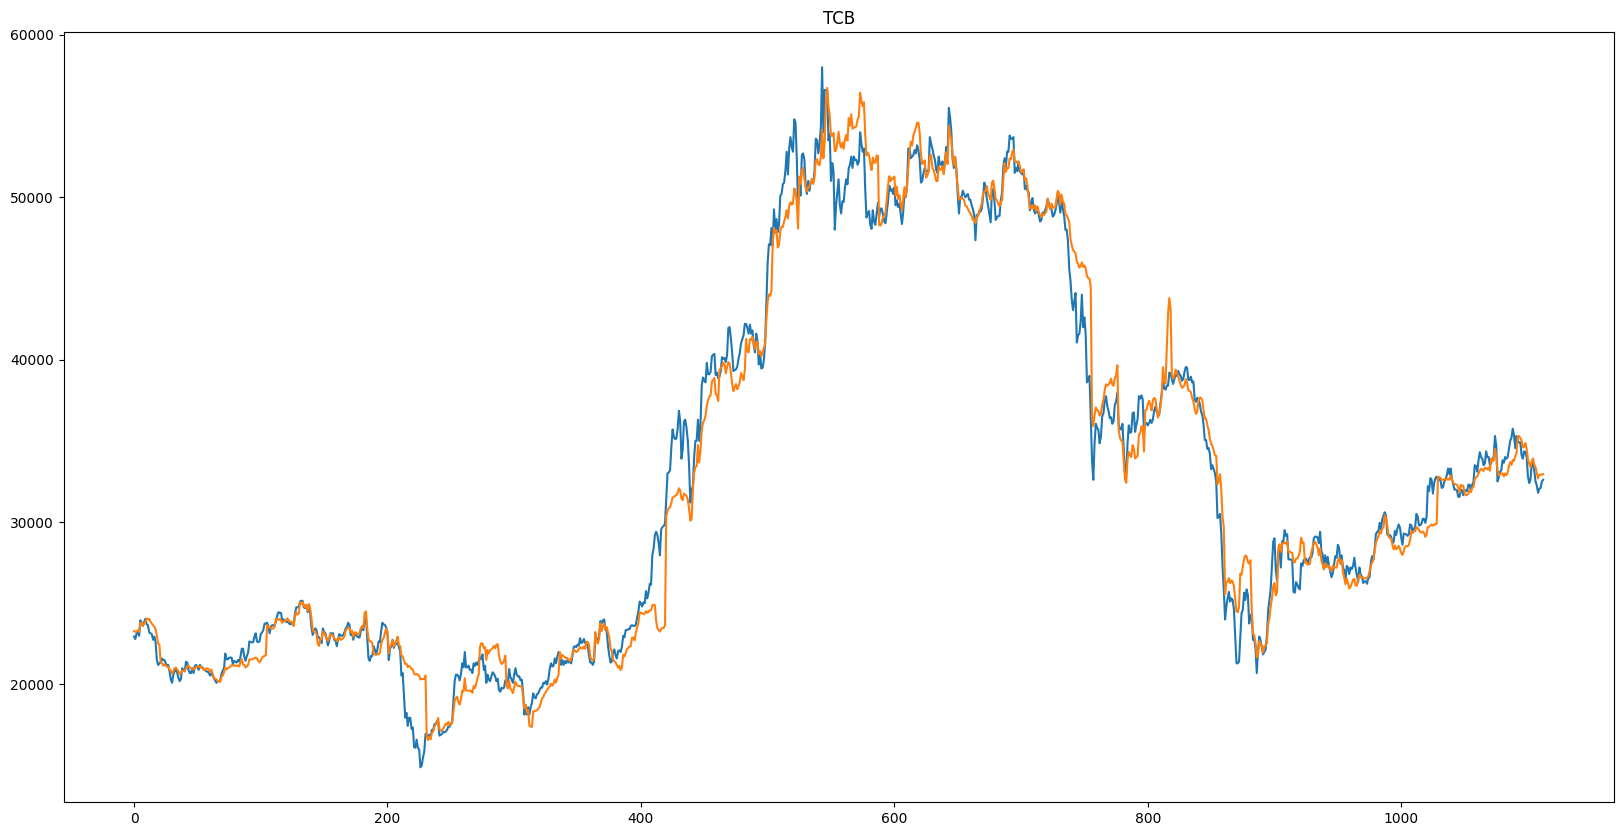

In [78]:
pred_y_EN = []
test_y = []

for i, value in enumerate(sum_train):
    ic_val = []
    y_test_all = []
    y_pred_all = []
    for j in range(num_set):
        Y_train = sum_train[i][j]['close']
        X_train = sum_train[i][j].drop('close', axis=1)
        y_test = sum_test[i][j]['close']
        y_test_all.append(y_test)
        x_test = sum_test[i][j].drop('close', axis=1)
        # model = LinearRegression().fit(X_train, Y_train)
        model_1 = LinearRegression()
        model_2 = xgb.XGBRegressor()
        model_3 = RandomForestRegressor()
        all_models = [model_1, model_2, model_3]
        s_train, s_test = stacking(all_models, X_train, Y_train, x_test,shuffle=True,n_folds=4)
        final_model = model_1
        final_model = final_model.fit(s_train, Y_train)
        y_pred = final_model.predict(s_test)
        y_pred_all.append(y_pred)
        spearman_corr, _ = spearmanr(y_test, y_pred)
        ic_val.append(spearman_corr)

    y_test_all = np.array(y_test_all).flatten()
    y_pred_all = np.array(y_pred_all).flatten()
    mean_ic = np.mean(ic_val)
    std_ic = np.std(ic_val)

    test_y.append(y_test_all)
    pred_y_EN.append(y_pred_all)

    mae = mean_absolute_error(y_test_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))
    plt.figure(figsize=(20, 10))
    plt.plot(y_test_all, label='Actual')
    plt.plot(y_pred_all, label='Predict')
    plt.title(code_ticker_taken[i])    

In [80]:
rmse

1587.476022016734